# Forecast Skill 
16 August 2023

A subsequent notebook analyzes the skill of rainfall probability forecasts: [ForecastProbabilitySkill.ipynb](https://anaconda.org/bfiedler/forecastprobabilityskill). This is the simpler notebook that analyzes the skill of temperature forecasts.

The Python we use here is elementary, but you will need to have learned Python elsewhere.  Some of the more "advanced" Python features we use are [list comprehension](https://realpython.com/list-comprehension-python/) and [applying zip to lists](https://datagy.io/python-zip-lists/).  

Let's consider a weather forecast of the sort you are familiar with: for example, the maximum air temperature at a location two days hence.  Was the forecast good or bad? After we have data for the future day, we can *verify* the forecast.  We can investigate if the forecast is more accurate than a [persistence forecast](https://glossary.ametsoc.org/wiki/Persistence_forecast), which is simply forecasting that the maximum temperature two days hence will be the same as today's maximum temperature. We can investigate if the forecast is more accurate than a [climatological forecast](https://glossary.ametsoc.org/wiki/Climatological_forecast), which could be simply forecasting that the maximum temperature would be the average maximum temperature for the particular month, over many previous years.

The forecasts we consider here are from [numerical weather prediction](https://en.wikipedia.org/wiki/Numerical_weather_prediction).  As a student of data science, you don't need to understand the physics in these models. But you should recognize the site forecasts are interpolated and extracted from a grid point in a grid that envelopes the Earth. 

For some reason, Australia has a tradition of offering datasets for forecast verification projects. Here we find a data set of 366 days of forecasts+observations, at hundreds of Australian automated weather stations: [Weather forecasting verification data (2015-05 to 2016-04) ](https://data.gov.au/data/dataset/weather-forecasting-verification-data-2015-05-to-2016-04/resource/16083945-3309-4c8a-9b64-49971be15878)

 **But you don't need to download any of this 605 Mb data.** I have already extracted a relevant subset of the data for you, in some CSV files. If you care, you can see [how I did it](https://anaconda.org/bfiedler/australiaverificationdata). 
 
But for this task, you only need to use this notebook: 

1. Go to *Cell* tab and *Run All*
2. Read the notebook
3. Scroll down to the *Student Exercises*, at the red bar
4. Note references to the quiz questions, and enter the answers to these questions in Canvas.

In [373]:
import os
from urllib.request import urlopen
import copy
import matplotlib.pyplot as plt
from datetime import datetime as dt
utc=dt.utcfromtimestamp

In [374]:
%%html
<style> div.text_cell_render{background-color: #ded; font-size: 18px}
                    .rendered_html code {background-color: #ded; color: #900; font-size: 16px}
                    .rendered_html pre {background-color: #ded; color: #900; font-size: 16px} 
</style>

In [375]:
# for automatically downloading data files from http://dsa5021.net/data/, or other url
def grabfile(urlfront,filename,filedir=""): # filedir could be data/, for example"
    urlpath = urlfront+filename
    filepath = filedir+filename
    if os.path.exists(filepath):
        print(filepath," already exists.  Delete it, if you want to overwrite.")
        return
    with urlopen(urlpath) as response:
        body = response.read()
    with open(filepath,'wb') as f:
        f.write(body)
    print("downloaded "+urlpath+" to "+filepath)
    return

In [376]:
yourname="Vignesh Murugan" # this label is put on your figures, your name is NOT metrprof

In [377]:
# I have made 6 CSV files for you from the Australian data.
filenames="""
31011_AIR_TEMP_MAX.csv
12038_AIR_TEMP_MAX.csv
09021_AIR_TEMP_MAX.csv
31011_AIR_TEMP_MIN.csv
12038_AIR_TEMP_MIN.csv
09021_AIR_TEMP_MIN.csv
""".strip().split()

usefile = 2 # you choose a file here

infilename=filenames[usefile]
print("you chose:",infilename)

you chose: 09021_AIR_TEMP_MAX.csv


In [378]:
# download the data file, if needed  
if not os.path.exists(infilename):
    grabfile("http://dsa5021.net/data/",infilename)
else:
    print("you already have "+infilename)

you already have 09021_AIR_TEMP_MAX.csv


In [379]:
#the filename contains information about the file you chose
sitenum=infilename.split('_')[0] # grabs sitenum from the filename you chose
siteinfo={
    '31011':'CAIRNS AERO',
    '12038':'KALGOORLIE-BOULDER AIRPORT',
    '09021':'PERTH AIRPORT'
}
sitename=siteinfo[sitenum]
varname=infilename[ len(sitenum)+1 : -4]
print("this is what you are studying:")
print(sitenum)
print(sitename)
print(varname)

this is what you are studying:
09021
PERTH AIRPORT
AIR_TEMP_MAX


In [380]:
# read and inspect the chosen data file
lines=open(infilename).readlines()
for line in lines: print(line,end='')
# use shift-O to scroll this output:

   utc      ob   clim   f1    f2    f3    f4    f5    f6    f7
1430431200 22.5  25.7   NA    NA    NA    NA    NA    NA    NA  
1430517600 22.5  21.8   NA    NA    NA    NA    NA    NA    NA  
1430604000 22.4  21.8  21.2   NA    NA    NA    NA    NA    NA  
1430690400 17.4  21.8  17.6  18.1   NA    NA    NA    NA    NA  
1430776800 20.2  21.8  20.2  20.2  19.8   NA    NA    NA    NA  
1430863200 22.3  21.8  22.0  21.7  21.6  21.1   NA    NA    NA  
1430949600 23.6  21.8  23.5  23.2  23.3  23.3  22.3   NA    NA  
1431036000 22.8  21.8   NA   23.5  23.2  23.2  22.4  22.1   NA  
1431122400 23.0  21.8  22.9   NA   23.2  23.4  23.4  21.9  21.9 
1431208800 24.2  21.8  24.8  25.1   NA   25.1  24.9  24.1  22.8 
1431295200 25.0  21.8  24.9  26.0  26.4   NA   25.5  25.0  25.2 
1431381600 23.7  21.8  24.0  24.4  25.3  26.2   NA   25.3  25.1 
1431468000 23.7  21.8  24.7  25.0  24.8  25.5  25.7   NA   25.6 
1431554400 26.1  21.8  26.7  27.1  26.5  26.8  27.0  26.6   NA  
1431640800 26.1  21.8  27.0

The numbers under `utc` is the date and time in [epoch time](https://www.epoch101.com/), in units of seconds. Our python function ```utc```, defined above, converts to the times you are familiar with. Here is an examples of using ```utc```:

In [381]:
testtime=utc(1430431200)
testtime

/var/folders/b0/0l4ksqs93r57m4lrp4v92c700000gn/T/ipykernel_88349/955289129.py:1: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  testtime=utc(1430431200)


datetime.datetime(2015, 4, 30, 22, 0)

In [382]:
testtime.month

4

In [383]:
print(testtime)

2015-04-30 22:00:00


`NA` means data is not available. The numbers are temperature in units of degree Celsius.
`ob` is the observed temperature at the site.  `f1`, `f2`, `f3` ... are the forecasts for the `ob`. `f1` is the the one-day forecast, issued one day prior. `f2` is the two-day forecast, issued two-days prior, and so on.  `f7` is the forecast from one week ago.

In [384]:
colnames = lines[0].strip().split()
print(colnames)
fkeys=colnames[3:]
print(fkeys) # forecast lead times, f1= 1 day, f2= 2 day ...

['utc', 'ob', 'clim', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']


Next we make a python dictionary for this data. We use `utc` for keys. The dictionary values will be another dictionary, with data. You may be wondering why I don't use a python DataFrame. My answer is that a dictionary
is adequate and [simple](https://www.quora.com/Are-there-advantages-of-Python-dictionaries-over-Pandas-dataframes)

In [385]:
edictf={} # the "e" means everything: obs,climate and forecast for the utc
for line in lines[1:]:
    q=line.strip().split()
    timeob = int(q[0]) # the utc of the ob
    edictf[timeob] = {} # make a dictionary within a dictionary
    ncol=len(colnames)
    for n in range(1,ncol):
        k=colnames[n] # the key
        v=q[n] # the value
        if v!='NA': v=float(v)
        edictf[timeob][k]=v
ekeys=sorted(edictf)
print(" edictf has",len(ekeys),"keys")

 edictf has 366 keys


In [386]:
testkey=ekeys[100]
print( testkey )
print( utc(testkey) ) # utc converts epoch time to UTC time
print( edictf[testkey] )

1439071200
2015-08-08 22:00:00
{'ob': 14.7, 'clim': 18.6, 'f1': 13.8, 'f2': 'NA', 'f3': 13.7, 'f4': 15.6, 'f5': 15.6, 'f6': 16.2, 'f7': 17.1}


/var/folders/b0/0l4ksqs93r57m4lrp4v92c700000gn/T/ipykernel_88349/2138114011.py:3: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print( utc(testkey) ) # utc converts epoch time to UTC time


In [387]:
#Look at edictf 
for k in ekeys[:10]:
    print(k)
    print(edictf[k])

1430431200
{'ob': 22.5, 'clim': 25.7, 'f1': 'NA', 'f2': 'NA', 'f3': 'NA', 'f4': 'NA', 'f5': 'NA', 'f6': 'NA', 'f7': 'NA'}
1430517600
{'ob': 22.5, 'clim': 21.8, 'f1': 'NA', 'f2': 'NA', 'f3': 'NA', 'f4': 'NA', 'f5': 'NA', 'f6': 'NA', 'f7': 'NA'}
1430604000
{'ob': 22.4, 'clim': 21.8, 'f1': 21.2, 'f2': 'NA', 'f3': 'NA', 'f4': 'NA', 'f5': 'NA', 'f6': 'NA', 'f7': 'NA'}
1430690400
{'ob': 17.4, 'clim': 21.8, 'f1': 17.6, 'f2': 18.1, 'f3': 'NA', 'f4': 'NA', 'f5': 'NA', 'f6': 'NA', 'f7': 'NA'}
1430776800
{'ob': 20.2, 'clim': 21.8, 'f1': 20.2, 'f2': 20.2, 'f3': 19.8, 'f4': 'NA', 'f5': 'NA', 'f6': 'NA', 'f7': 'NA'}
1430863200
{'ob': 22.3, 'clim': 21.8, 'f1': 22.0, 'f2': 21.7, 'f3': 21.6, 'f4': 21.1, 'f5': 'NA', 'f6': 'NA', 'f7': 'NA'}
1430949600
{'ob': 23.6, 'clim': 21.8, 'f1': 23.5, 'f2': 23.2, 'f3': 23.3, 'f4': 23.3, 'f5': 22.3, 'f6': 'NA', 'f7': 'NA'}
1431036000
{'ob': 22.8, 'clim': 21.8, 'f1': 'NA', 'f2': 23.5, 'f3': 23.2, 'f4': 23.2, 'f5': 22.4, 'f6': 22.1, 'f7': 'NA'}
1431122400
{'ob': 23.0, 

# hack!

[What does Hack Mean?](https://www.techopedia.com/definition/27859/hack-development) I like that answer. I will cut and paste it here:

*Hack, in the context of development, has two meanings:*

1.  *A hack is an inelegant solution to a problem. In this sense, a hack gets the job done but in an inefficient, un-optimal or ugly way.*
1. *To hack can also mean to program with exceptional skill. In this sense, a hacker produces code that not only accomplishes the task, but does so in an efficient and unique manner.*

To assess the skill of  persistence forecasts, I hacked this notebook to allow substituting model forecast predictions with persistence forecast predictions.  Is this efficient or ugly? 

Don't set `hack=True` until you are instructed to do so later in the notebook.

In [388]:
hack=False # True will use substitute persistence forecasts instead of model forecasts

In [389]:
edictp=copy.deepcopy(edictf) # ready to hack the forecast data
for k in ekeys:
    for f in fkeys:
        n=int(f[1])
        priortime=k-n*86400 # for extracting prior ob
        priorob='NA' #default is "Not Available"
        if priortime in edictp: # prior ob exists
            priorob=edictp[priortime]['ob'] # get prior ob
        edictp[k][f]=priorob # replace model forecast with prior ob

In [390]:
if hack:
    edict=edictp # point edict to hacked persistence forecast dictionary
    forecast='persistence'
else:
    edict=edictf # point edict to original model forecast dictionary
    forecast='model'
print("you are using:",forecast,"forecasts")

you are using: model forecasts


## end hack

Let's assess the error in the forecasts, meaning the numerical difference between the forecast and the observation. We are interested in the average error over all the forecasts. We calculate *Root Mean Square Error* `RMSE` and *Mean Absolute Error* `MAE`. 
[RMSE and MAE](http://www.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm)

In order to do arithmetic, we will reject all days that had missing values (NA) in `ob` or `clim`  or `f1` or `f2` ... 

Note that `f7` is not necessarily needed in a study of `f1`.  But we choose to do the forecast comparisons on the same set of events. All forecasts must be available.

There is a surprising amount of missing data.  I am not sure why.

In [391]:
gkeys=[] #gkeys are "good" keys
for k in ekeys:
    if 'NA' in edict[k].values(): continue # one or more NA, throw out key
    gkeys.append(k)
print("number of keys =",len(ekeys),"    number of keys with no missing values",len(gkeys))    

number of keys = 366     number of keys with no missing values 227


In [392]:
# extracts values from a list of lists
# kk is the subset of keys of adict that you want to include
# ka = ob, clim, or f1, ... , the key of the inner list
# the values for ka are put sequentially into a list
def getv(adict,kk,ka): 
    w=[] #empty list
    for k in kk:
        w.append(adict[k][ka]) # fill the list
    return w   

In [393]:
# makes the lists oo, cc, ffs['f1'] ... will be used in plotting and assessment of skill
ffs={} 
oo=getv(edict,gkeys,'ob') # all the ob
cc=getv(edict,gkeys,'clim') # all the clim
tdays=[(x-gkeys[0])/86400 for x in gkeys] # elapsed days
for fk in fkeys:
    ffs[fk]=getv(edict,gkeys,fk) # all the f1, f2, ... 

We have observations in list `oo`, expectation from past climate data in `cc`, day number in `tdays`, 
and seven forecasts, from one day prior, two days prior... in `f1`, `f2` and so on...

Make a quick plot. Compare obs, climate and a forecast.
It shold be obvious that f1 (the 1-day forecast, the forecast for tomorrow)
is better than using climatology as a forecast.

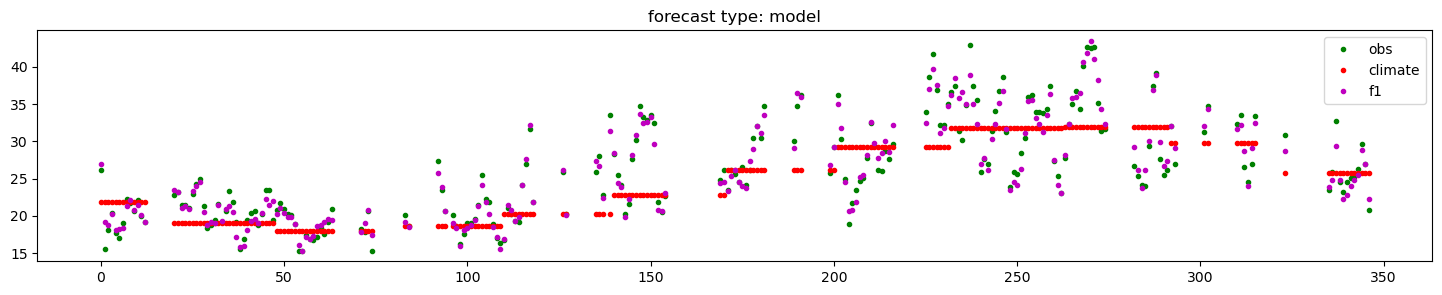

In [394]:
plt.figure(figsize=(18,3)) 
plt.plot(tdays,oo,'g.',label='obs') #green dot for ob
plt.plot(tdays,cc,'r.',label='climate') #red dot for climatology
plt.plot(tdays,ffs['f1'],'m.',label='f1') #magenta dot for forecast
plt.title("forecast type: "+forecast)
plt.legend(); # <- notice last semi-colon to supress messages

In [395]:
#assess numerical difference between two lists
def meane(a,b):
    assert len(a)==len(b)
    sumsq = 0 # sum of square difference
    suma = 0 # sum of absolute difference
    z = zip(a,b)
    for x,y in z:
        sumsq += (x-y)**2
        suma += abs(x-y)
    n=len(a)
    # return both 'root mean square error' and 'mean absolute error'
    return (sumsq/n)**.5 , suma/n   

In [396]:
# find the error for using climate to predict observation
rmsec, maec = meane(oo,cc)
print('RMSE climate = ',rmsec,'     MAE climate = ',maec) 

RMSE climate =  4.604455800185189      MAE climate =  3.553744493392071


In [397]:
# find the error for using f1 to predict observation
rmsef1, maef1 = meane(oo,ffs['f1'])
print('RMSE one-day forecast = ',rmsef1,'     MAE one-day forecast = ',maef1) 

RMSE one-day forecast =  1.2943115122523245      MAE one-day forecast =  0.9418502202643172


Not surprising, the one-day model forecast is better (on average) than using the climate value for the forecast.
We formalize this comparison with a *skill score*.
(https://en.wikipedia.org/wiki/Forecast_skill)

In [398]:
skills=[] # for RMSE skill
skilla=[] # for MAE skill
skilld={'clim':0.} # will be useful for plots
print("forecast type:",forecast)
print( "using    RMSE climate = {:6.3}     MAE climate =  {:6.3}\n".format(rmsec,maec) ) 
print("forecast    RMSE    Skill    MAE    Skill")
for fk in fkeys:
    ff=ffs[fk]  
    rmsef , maef = meane(oo,ff)
    sks = 1. - rmsef/rmsec
    ska = 1. - maef/maec
    outform="{}        {:6.3}  {:6.3}  {:6.3}  {:6.3}"
    outstring=outform.format(fk,rmsef,sks,maef,ska)
    print(outstring)
    skills.append(sks) # skill using RMSE, for bar graph
    skilla.append(ska) # skill using MAE, for bar graph
    skilld[fk]=sks # RMSE skill in this dictionary, for scatter plot labels

forecast type: model
using    RMSE climate =    4.6     MAE climate =    3.55

forecast    RMSE    Skill    MAE    Skill
f1          1.29   0.719   0.942   0.735
f2          1.55   0.663    1.09   0.694
f3          1.71   0.629    1.25   0.647
f4          1.98   0.569    1.46   0.589
f5          2.42   0.475    1.86   0.476
f6          2.89   0.372    2.16   0.393
f7          3.28   0.287    2.44   0.312


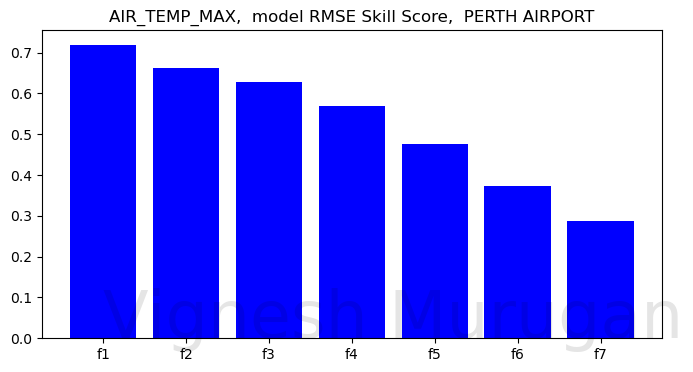

In [399]:
plt.figure(figsize=(8, 4))
plt.title(varname+',  '+forecast+' RMSE Skill Score,  '+sitename)
color='blue'
if hack: color='red'
plt.bar(fkeys,skills,color=color) #note skills
plt.text(.0,.0,yourname,fontsize=48, alpha=.1)
plt.savefig('skillscoresRMSE'+forecast+'.png')

I am pleasantly surprised that the seven-day forecast from the model still has positive skill.

Below, we see there is not much difference in skill score when using `MAE` instead of `RMSE`.

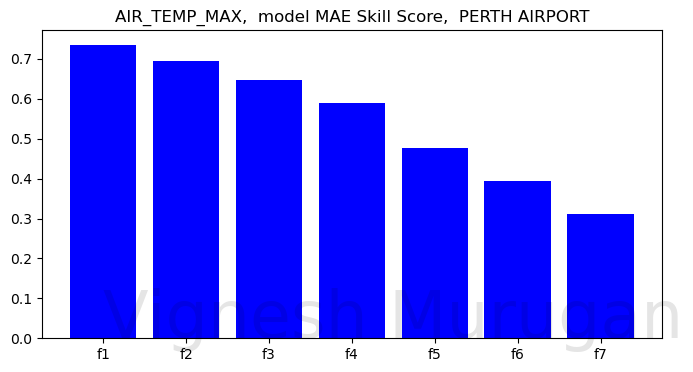

In [400]:
plt.figure(figsize=(8, 4))
plt.title(varname+',  '+forecast+' MAE Skill Score,  '+sitename)
plt.bar(fkeys,skilla,color=color) # note skilla
plt.text(.0,.0,yourname,fontsize=48, alpha=.1)
plt.savefig('skillscoresMAE'+forecast+'.png');

In [401]:
#this format will be useful for some of the plots below
skt="skill score={: .2f}"
skt.format(skilld['f1'])

'skill score= 0.72'

## scatter plots
The observations compared with the various forecasts

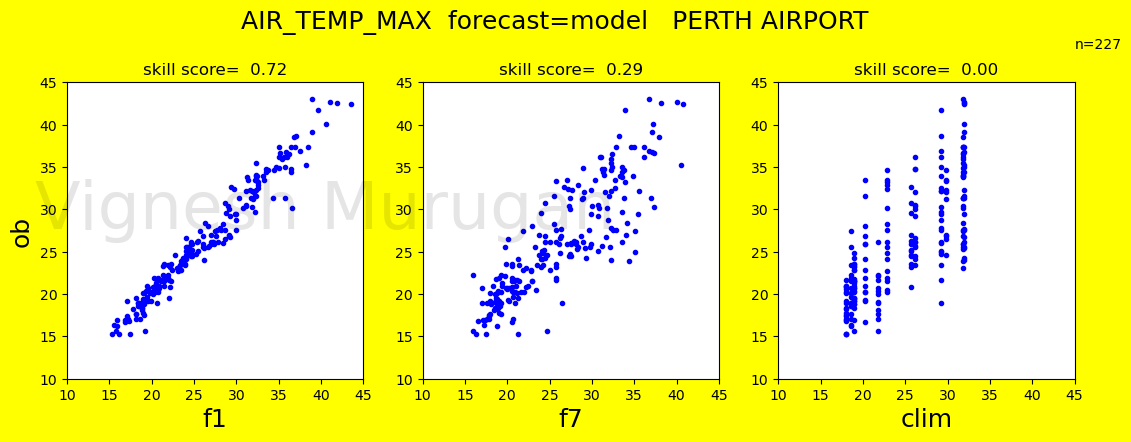

In [402]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,4),facecolor='yellow')
if 'MAX' in varname:
    tlo=10
    thi=45
else:
    tlo=-5
    thi=30
fsz=18; 
tcks=range(tlo,thi+1,5)

color='blue'
if hack: color='red'

skt="skill score= {: .2f}"

title=skt.format(skilld['f1'])  
ax[0].set_xlim(tlo,thi); ax[0].set_ylim(tlo,thi)
ax[0].plot(ffs['f1'],oo,'.',color=color)
ax[0].set_xlabel('f1',fontsize=fsz)
ax[0].set_ylabel('ob',fontsize=fsz)
ax[0].set_xticks(tcks);ax[0].set_yticks(tcks)
ax[0].set_title( title )
ax[0].set_aspect('equal')

title=skt.format(skilld['f7'])  
ax[1].set_xlim(tlo,thi); ax[1].set_ylim(tlo,thi)
ax[1].plot(ffs['f7'],oo,'.',color=color)
ax[1].set_xlabel('f7',fontsize=fsz)
ax[1].set_xticks(tcks);ax[1].set_yticks(tcks)
ax[1].set_title( title )
ax[1].set_aspect('equal')

title=skt.format(skilld['clim'])  
ax[2].set_xlim(tlo,thi); ax[2].set_ylim(tlo,thi)
ax[2].plot(cc,oo,'.',color=color)
ax[2].set_xlabel('clim',fontsize=fsz)
ax[2].set_xticks(tcks);ax[2].set_yticks(tcks)
ax[2].set_title( title )
ax[2].set_aspect('equal')

figtitle=varname +'  '+'forecast='+forecast+'   '+sitename
fig.text(.5,1,figtitle,ha='center',fontsize=fsz)
fig.text(.1,.5,yourname,fontsize=48, alpha=.1)
fig.text(.90,.95,'n='+repr(len(oo)))
outpng=infilename[:-4]+'_'+'scatter'+'_'+forecast
fig.savefig(outpng+'.png' , bbox_inches='tight', facecolor='yellow', transparent=False)

## Time series plots
The above scatter plots don't use any time data. Next we plot the forecast, observation, and climate as time series. Perhaps we will see that the forecast struggle more in certain seasons.  Or see that bad forecasts are grouped in a series of days. The observation is a green dot.  The difference between the observation and the forecast is a red line segment if the obs is warmer than the forecast, and blue if colder.

In [403]:
def fplot(tdays,oo,ff,lab,title):
    rmse,mae=meane(oo,ff)
    rootmeansq='{:.3f}'.format(rmse)
    quick, simple = plt.subplots(figsize=(18,3)) 
    simple.plot(tdays,oo,'.g',lw=1,ms=3,zorder=1)
    for i in range(0,len(tdays)):
        if oo[i]>ff[i] : 
            segcol='r'
        else:
            segcol='b'
        simple.plot((tdays[i],tdays[i]),(ff[i],oo[i]),segcol,linewidth='1.',zorder=0)
    simple.set_xticks(range(0,360,30)) # x tick marks every 30
    simple.set_ylabel('degree C') 
    simple.set_xlabel('day')
    simple.set_title(title,fontsize=22)
#bb    simple.text(.1,.2,'your name here!',fontsize=72, alpha=.1, transform = simple.transAxes)
    simple.text(.05,.8,'RMSE='+rootmeansq,transform=simple.transAxes)
    quick.savefig(lab+'.png',dpi=144) 

AIR_TEMP_MAX  ob vs. f1  model  PERTH AIRPORT [27.0, 19.2, 18.8, 20.3, 18.1, 18.2, 18.4, 21.3, 22.1, 20.8]
AIR_TEMP_MAX  ob vs. f2  model  PERTH AIRPORT [27.0, 19.6, 17.7, 19.7, 18.1, 18.1, 18.1, 20.9, 21.6, 20.9]
AIR_TEMP_MAX  ob vs. f3  model  PERTH AIRPORT [27.0, 19.2, 18.7, 18.0, 18.3, 18.2, 18.6, 20.3, 21.2, 21.3]
AIR_TEMP_MAX  ob vs. f4  model  PERTH AIRPORT [27.3, 18.8, 17.9, 19.6, 18.6, 18.1, 19.7, 19.7, 21.1, 20.1]
AIR_TEMP_MAX  ob vs. f5  model  PERTH AIRPORT [27.0, 21.7, 18.4, 20.0, 19.8, 17.1, 19.9, 20.7, 20.5, 19.3]
AIR_TEMP_MAX  ob vs. f6  model  PERTH AIRPORT [26.7, 20.6, 18.5, 18.6, 20.4, 21.1, 19.2, 20.9, 20.9, 20.2]
AIR_TEMP_MAX  ob vs. f7  model  PERTH AIRPORT [25.7, 24.7, 18.4, 20.6, 19.2, 20.7, 20.9, 19.3, 20.9, 20.0]
AIR_TEMP_MAX  ob vs. climate  PERTH AIRPORT [21.8, 21.8, 21.8, 21.8, 21.8, 21.8, 21.8, 21.8, 21.8, 21.8]


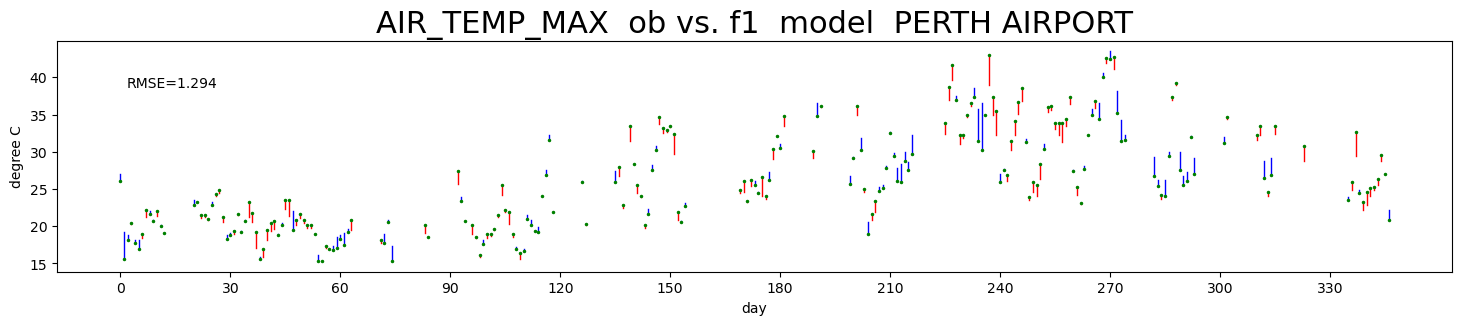

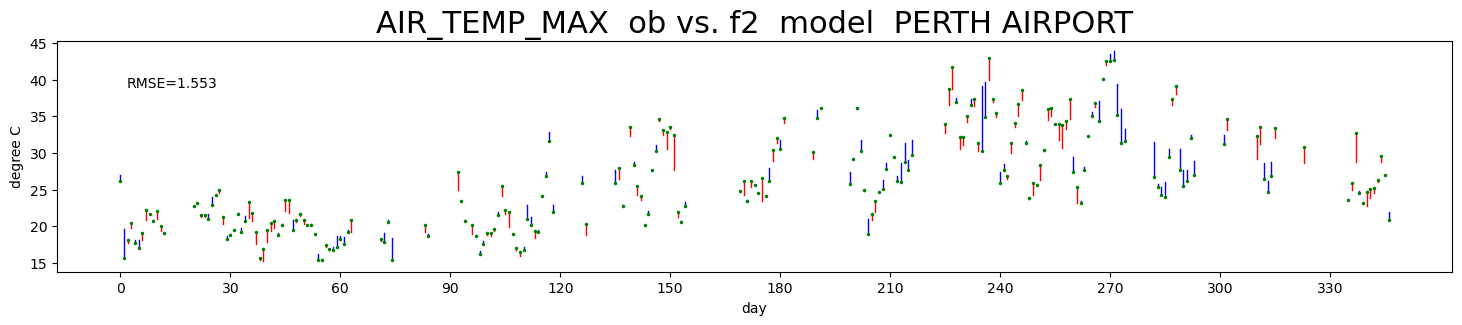

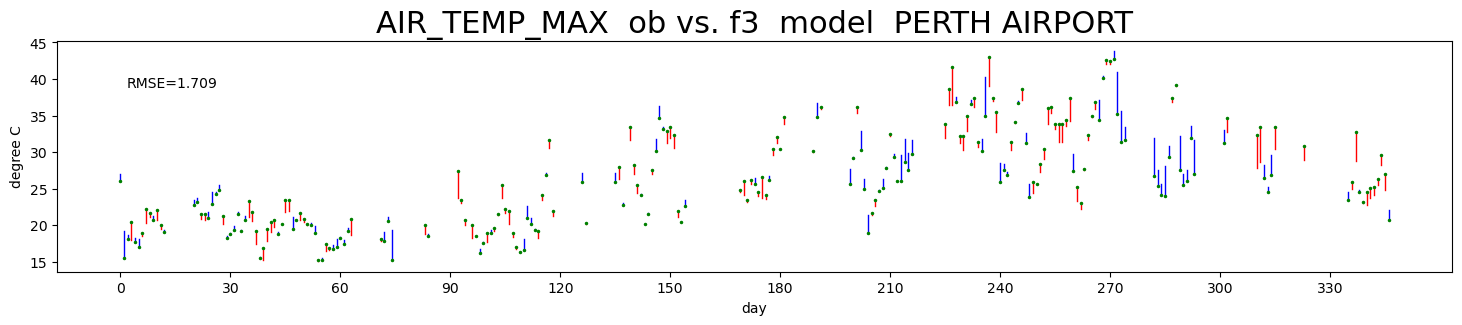

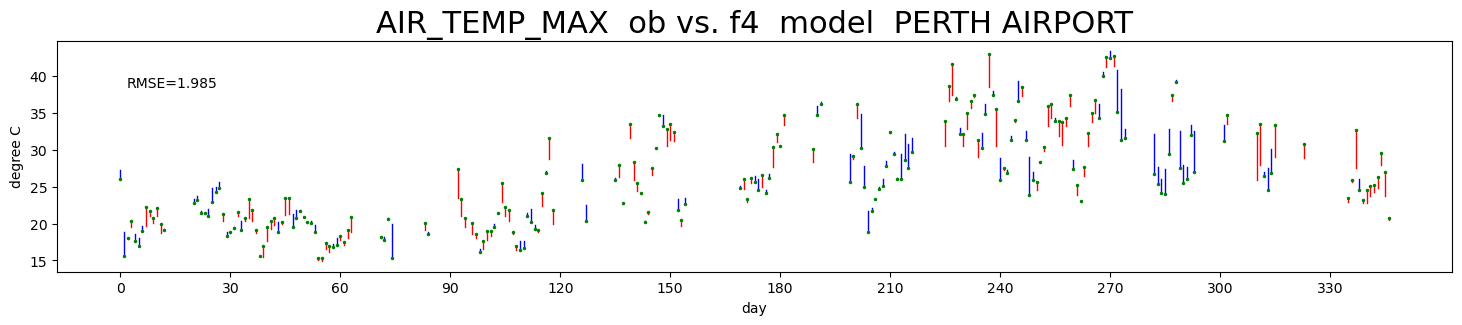

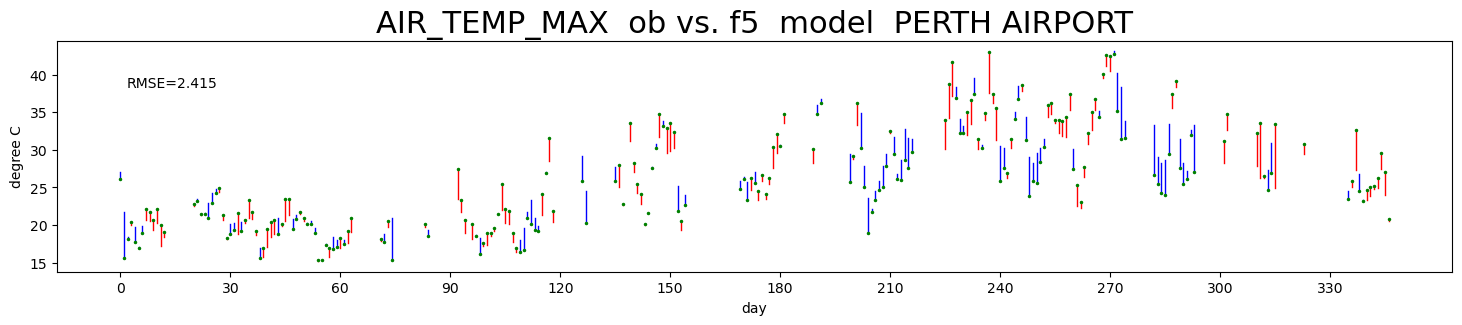

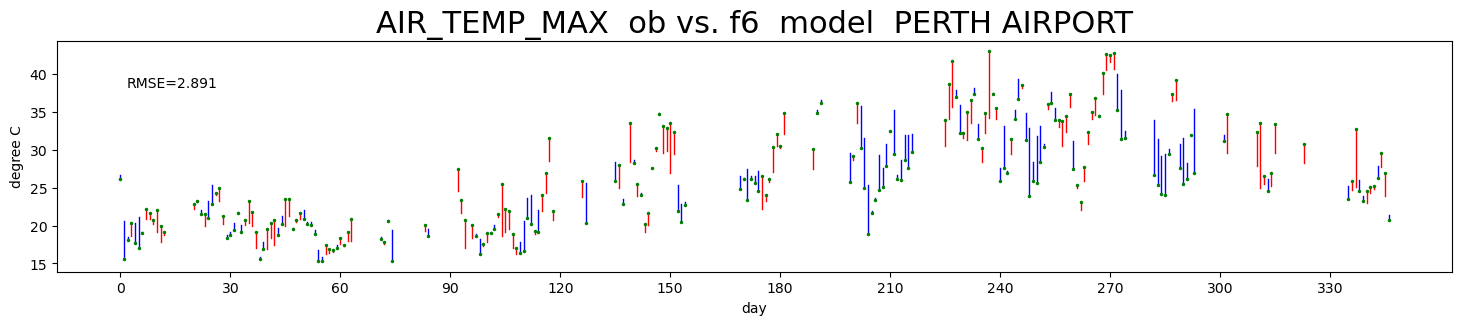

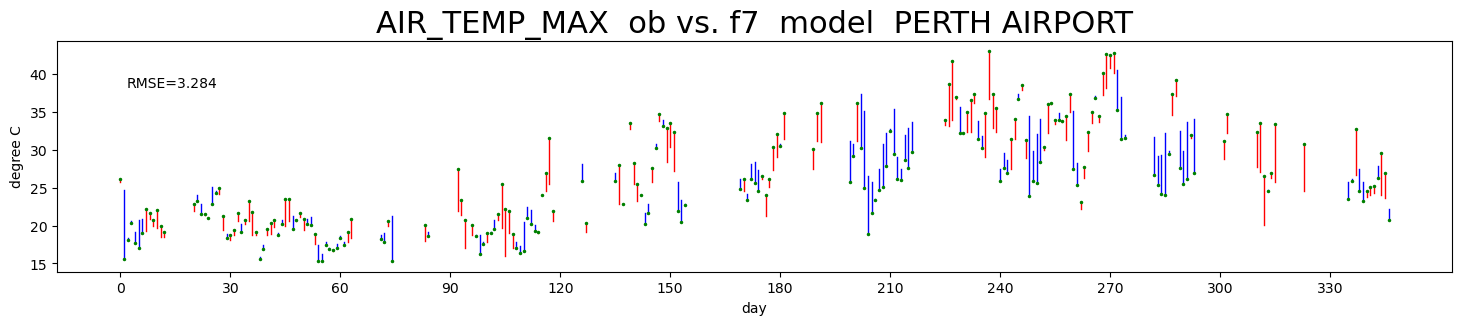

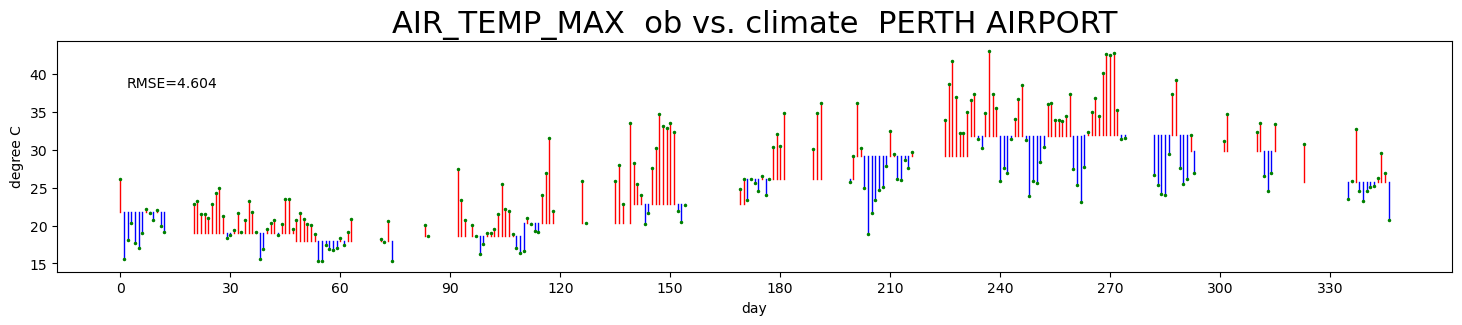

In [404]:
for thef in fkeys:
    outpng=infilename[:-4]+'_'+thef+'_'+forecast
    title = varname+'  ob vs. '+thef+'  '+forecast+'  '+sitename
    print(title,ffs[thef][:10])
    fplot(tdays,oo,ffs[thef],outpng,title)
    
title = varname+'  ob vs. climate  '+sitename
print(title,cc[:10])
outpng=infilename[:-4]+'_clim'
fplot(tdays,oo,cc,outpng,title)

<hr style="height:30px;border:none;background-color:#f00;" />

# Student Exercises

## using the dictionary
Here is what should a simple exercise to make sure you understand our `edictf`, which has dictionaries within the dictionary.  For file `09021_AIR_TEMP_MAX.csv`, how many `NA` are within are in `f1`, `f2` ... `f7`?
Give your answer as a list of 7 integers.  Hint: `nas[-1]` is 32.

In [405]:
#STUDENTS: how many "NA" 
nas=[0,0,0,0,0,0,0]
for k in edictf.keys():
    for m in range(7):
       forecast_key = f"f{m + 1}"
       if edictf[k][forecast_key] == "NA": 
            nas[m] += 1 

print(infilename)
print("forecast type:",forecast)
print(nas)
# nas item will not be only 0
# your answer will be submitted in the quiz

09021_AIR_TEMP_MAX.csv
forecast type: model
[25, 26, 27, 28, 29, 29, 32]


* In the quiz, choose what you see for `print(nas)`

##  persistence forecasts
Using the `hack=True` switch above, study the persistence forecasts for `usefile=2`.
Upload the images for the scatter plots, like you see here:
http://metr4330.net/~bfiedler/secret/skill/

**When done, don't forget to change back to `hack=False`, and rerun the notebook.**

In your quiz you are asked: 
* For a persistence forecast `f2`, you see the number is the same as `ob` in how may rows prior in the file?
* For which forecasts is the skill *negative* for persistence?


## Contingency table

Suppose you forecast events, such as the occurrence of frost tomorrow morning, that have two possible values, **yes** or **no**.  Tomorrow morning we can determine whether frost did occur, again with two possible values, 
**yes** or **no**.   We can the verify the forecasts. For many such forecasts, we can  can the various ways our forecasts were correct (True) or not (False).  We can put those 4 integers in a *contingency table*:

|event |ob yes|ob no|
|-----|-----|-----|
|**forecast yes**| Hit | False Alarm|
|**forecast no**|Miss | Correct Negative |

For a concept that is so simple, you will see a variety of styles for a [contingency table](http://www.eumetrain.org/data/4/451/english/msg/ver_categ_forec/uos1/uos1_ko1.htm). But for weather forecasting, I believe the style most common is as above, with forecast in rows and observations in columns.
For example, the [2x2 example in the wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion) has rows and columns transposed from above.

You may see different jargon from the above. You might see:

|event |ob yes|ob no|
|-----|-----|-----|
|**forecast yes**| true positive  | false positive|
|**forecast no**|false negative | true negative |

The *positive* and *negative* refers to the forecast of *yes* and *no*. The *true* and *false* refers to whether the forecast is confirmed by the observation. 

You might see two letter symbols, for the four categories:

|event |ob yes|ob no|
|-----|-----|-----|
|**forecast yes**| TP | FP|
|**forecast no**| FN | TN|

How do I keep from flipping FP and FN in my brain? Is P for forecast or observation? I remind myself False Positive is the same as False Alarm, and an Alarm is something you do *before* an event.  It is a P forecast. It is F because the forecast did not conform with the observation. 

**In ```TP``` ```FP``` ```FN``` ```TN```, the second letter is the forecast, the first letter is the verification.**



Here we investigate a somewhat silly example of a *heat warning*, a warning that the daily maximum temperature is 5 C above the average climate expectation for that month.

In [406]:
#STUDENTS, calculate TP FP FN TN
fn='f1' # choose the forecast, f1, f2, ...f7.  
ff=ffs[fn]
TP=0
FP=0
FN=0
TN=0
dt=5 # you choose temperature increment above climatological forecast
for f,o,c in zip(ff,oo,cc):
    print("f=",f,"  o=",o,"  c=",c) # delete this after you understand
    if f>(c+dt): 
        if o>(c+dt):
            TP+=1
        else:  
            FP += 1 
    else:  
        if o > (c + dt):  
            FN += 1  
        else:  
            TN += 1 


f= 27.0   o= 26.1   c= 21.8
f= 19.2   o= 15.6   c= 21.8
f= 18.8   o= 18.1   c= 21.8
f= 20.3   o= 20.4   c= 21.8
f= 18.1   o= 17.7   c= 21.8
f= 18.2   o= 17.0   c= 21.8
f= 18.4   o= 19.0   c= 21.8
f= 21.3   o= 22.2   c= 21.8
f= 22.1   o= 21.7   c= 21.8
f= 20.8   o= 20.7   c= 21.8
f= 21.4   o= 22.1   c= 21.8
f= 20.1   o= 20.0   c= 21.8
f= 19.1   o= 19.1   c= 21.8
f= 23.5   o= 22.8   c= 19.0
f= 23.2   o= 23.2   c= 19.0
f= 21.1   o= 21.5   c= 19.0
f= 21.3   o= 21.5   c= 19.0
f= 20.9   o= 21.0   c= 19.0
f= 23.3   o= 22.9   c= 19.0
f= 24.0   o= 24.3   c= 19.0
f= 24.5   o= 24.9   c= 19.0
f= 20.5   o= 21.3   c= 19.0
f= 18.8   o= 18.3   c= 19.0
f= 19.1   o= 18.8   c= 19.0
f= 19.0   o= 19.4   c= 19.0
f= 21.5   o= 21.6   c= 19.0
f= 19.3   o= 19.2   c= 19.0
f= 20.9   o= 20.7   c= 19.0
f= 21.3   o= 23.3   c= 19.0
f= 20.5   o= 21.8   c= 19.0
f= 17.1   o= 19.2   c= 19.0
f= 15.8   o= 15.6   c= 19.0
f= 15.9   o= 16.9   c= 19.0
f= 18.1   o= 19.5   c= 19.0
f= 19.3   o= 20.4   c= 19.0
f= 19.6   o= 20.7   

Using `fn='f7'`, does your cell below show the above correct output?

If so, switch to using `fn='f1'`, take a screen shot of your cell below. 

**STUDENTS: Post the screenshot on your web page.**

In [407]:
print(infilename)
print("weather event: temperature",dt,"C above climatology")
print("forecast type:",forecast,fn)
print("TP=",TP,"   FP=",FP)
print("FN=",FN,"   TN=",TN)

09021_AIR_TEMP_MAX.csv
weather event: temperature 5 C above climatology
forecast type: model f1
TP= 32    FP= 4
FN= 7    TN= 184


## A few more metrics extracted from a contingency table

**Students: no answers need to be submitted from this section**

The forecasts would be perfect if FN=0 and FP=0.  To assess a level of imperfection, we can combine these 4 integers in various ways:  [Methods for dichotomous (yes/no) forecasts](https://www.cawcr.gov.au/projects/verification/#Methods_for_dichotomous_forecasts).

That is too many ways for me... If FP>0, just how bad is it?  A common calculation is the *False Alarm Ratio* FP/(TP+FP).  Simple enough.  But there is trouble ahead.

As discussed in [False alarm ratio](https://www.statisticshowto.com/false-alarm-ratio-definition/) there
is another quantity with FP in the numerator, [False alarm rate](https://www.statistics.com/famous-errors-in-statistics-its-not-what-you-might-think/).  
Oh my: [CORRIGENDUM: False Alarm Rate or False Alarm Ratio? ](https://journals.ametsoc.org/view/journals/wefo/24/5/2009waf2222300_1.xml).  Okay, let's use POFA instead of FAR:

In [409]:
if TP!=0 and TN!=0:
    POFA = FP/(TP+FP) # also called False Alarm Ratio, or FAR
    POFD  = FP/(TN+FP) # also call False Alarm Rate, or FAR
    print("Probability of False Alarm =",POFA)
    print("Probability of False Detection =",POFD)

Probability of False Alarm = 0.1111111111111111
Probability of False Detection = 0.02127659574468085


In [412]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
bias_score = (TP + FP) / (TP + FN)

print("accuracy =", accuracy)
print("bias score =", bias_score)

accuracy = 0.9515418502202643
bias score = 0.9230769230769231


But I confess that *Probability of False Detection* doesn't make sense to me as an ideal name for FP/(TN+FP).  If you think you know why the name is okay, you are welcome to explain it to me.

By the way, as a name for a variable in a computer program, using a name with two characters is usually better than only one.  In a mathematical discussion, a variable name with one character is preferred (otherwise FP could be interpreted as F multiply P).  So to follow [CORRIGENDUM: False Alarm Rate or False Alarm Ratio? ](https://journals.ametsoc.org/view/journals/wefo/24/5/2009waf2222300_1.xml):

|event |ob yes|ob no|
|-----|-----|-----|
|**forecast yes**| X | Z|
|**forecast no**| Y | W|

And yet another possibility is as in the book *Statistical Methods in Atmospheric Sciences* by D. S. Wilks :

|event |ob yes|ob no|
|-----|-----|-----|
|**forecast yes**| a | b|
|**forecast no**| c | d|

Check this out:
https://www.cawcr.gov.au/projects/verification/#Methods_for_dichotomous_forecasts
Using the same settings as for your screenshot, `fn='f1'`, and using TP, FP, FN and TN, we can calculate, for example the:
* Accuracy
* Bias score

I can't get too excited about that...

# forecast bias
What can we do with scatter plots like the one below?  We might want to assess if the forecast is consistently too cold or too hot. And also ask if hot observations are often warmer than the forecast, and cold observations are colder than the forecast. And so on. If the answer is affirmative for such questions, we could conclude the model is *biased*.  We might want to fix the physics the forecast model.  We also might want to leave the model unchanged and just expect the model output needs to be adjusted a bit to compensate for the model bias. Just read the first paragraph in [Model Ouput Statistics](https://en.wikipedia.org/wiki/Model_output_statistics). And maybe read the first paragraph here about [MOS](https://vlab.noaa.gov/web/mdl/mos).

We will see below that there is very little adjustment that needs to be done. The Australian forecast products have already applied MOS adjustments, based on many prior years of experience with the model.

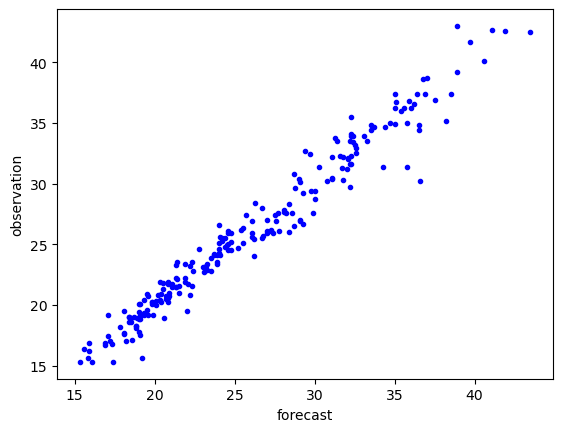

In [346]:
plt.plot(ff,oo,'b.')
plt.ylabel('observation')
plt.xlabel('forecast');

What do we often do with scatter plots? We fit a line to the data points. Let's do that, and then explain the significance. And let's keep this line fitting simple: [Introduction to Linear Regression in Python](https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0).

In [347]:
def mean(a):
    return sum(a)/len(a)

In [348]:
#sample covariance, of two lists
def cov(a,b):
    if len(a)!=len(b): return None
    am=mean(a)
    bm=mean(b)
    n=len(a)
    total=0.
    for i in range(n):
        total+=(a[i]-am)*(b[i]-bm)
    return total/(n-1)   

Fitting $$y=\alpha + \beta x$$

In [349]:
beta=cov(oo,ff)/cov(ff,ff)
beta

0.9974433789784176

In [350]:
alpha=mean(oo)-beta*mean(ff)
alpha

0.16149681113494196

In [351]:
# here is the linear function of the forecast that
# best fits the observations:
ofit=[alpha+beta*x for x in ff]

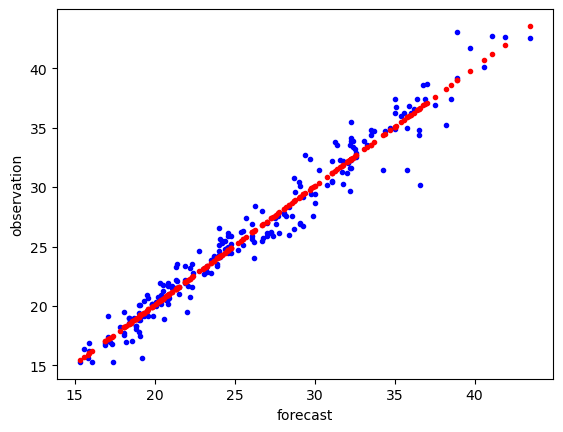

In [352]:
# here it is, the fitted line
plt.plot(ff,oo,'b.') # the actual observations
plt.plot(ff,ofit,'r.') # the linear fit to the forecast
plt.ylabel('observation')
plt.xlabel('forecast');

Though we have *observation* on the y-axis, for the red points it could be labeled *a better forecast this year would have been this*.

In [353]:
error1=[(x-y)**1 for x,y in zip(ff,oo)]
error2=[(x-y)**2 for x,y in zip(ff,oo)]
print(mean(error1),mean(error2))

-0.09515418502202634 1.675242290748899


In [354]:
# now interpret ofit as an alternative for ff:
error1=[(x-y)**1 for x,y in zip(ofit,oo)]
error2=[(x-y)**2 for x,y in zip(ofit,oo)]
print(mean(error1),mean(error2))
# mean(error2) is a little bit better

3.5761897603784776e-15 1.6659154638747595


In [356]:

# Experiment with adjusted betas
adjustments = [0.99, 1.01, 1]
for adjustment in adjustments:
    beta_adjusted = adjustment * cov(oo, ff) / cov(ff, ff)
    ofit_adjusted = [mean(oo) - beta_adjusted * mean(ff) + beta_adjusted * x for x in ff]
    
    # Calculate errors for adjusted beta
    error1_adjusted = [(x - y)**1 for x, y in zip(ofit_adjusted, oo)]
    error2_adjusted = [(x - y)**2 for x, y in zip(ofit_adjusted, oo)]
    
    print(f"\nAdjusted Beta ({adjustment * 100:.0f}%):")
    print("Mean Error1:", mean(error1_adjusted))
    print("Mean Error2:", mean(error2_adjusted))


Adjusted Beta (99%):
Mean Error1: 3.670094086690385e-15
Mean Error2: 1.670063313128698

Adjusted Beta (101%):
Mean Error1: 2.3945603209536417e-15
Mean Error2: 1.670063313128698

Adjusted Beta (100%):
Mean Error1: 3.5761897603784776e-15
Mean Error2: 1.6659154638747595


There is only a **tiny** improvement by applying additional MOS. And the tiny improvement is cheating: we used knowledge from the *end* of the forecast year to calculate alpha and beta, to improve forecasts *during* the forecast year. The Australian system legitimately used results from previous years, meaning alpha and beta from previous years, to apply MOS to the forecast year. And the MOS did very well in the forecast year.  There is no indication that it needs to be improved. The model bias has already been removed. I offer my apologies for not having a significant MOS exercise for you... 

**STUDENTS:** here is the question for you. Do we have faith in my linear regression? Let's play with:

`beta = cov(oo,ff)/cov(ff,ff)`

If you hack with:

`beta = 0.99*cov(oo,ff)/cov(ff,ff)`

or

`beta = 1.01*cov(oo,ff)/cov(ff,ff)`,

is `mean(error2)` reduced in either of those experiments?
Give your answer in the quiz.

# Climate warming?

This notebook was in introduced to be about forecast skill.  But the data provides an opportunity to ignore the forcasts, and just compare the temperature observation with the average of those observations from previous years,
the climate  in `clim`. The questions the quiz will ask you: 

* Which station has the most `NA` observations for the three files `AIR_TEMP_MIN`? 
* What is the most common date of `NA` found these 6 files? 
* Find the average of "observation minus climate" in each of the 6 files. Do NOT include `clim` in an average  if `ob` is missing. What is largest difference? Hint: >1.0 
* After finding 6 numbers for the average of "observation minus climate" for the six files, what is the average of those numbers? 

In [367]:
#STUDENTS: this function needs to be completed
def obminusclim(fnm): 
    lines = open(fnm,'r').readlines()
    total = 0
    n = 0
    for line in lines[1:]:
        q = line.split()
        timeob = q[0]
        ob = q[1]
        clim = q[2]
        if ob != "NA":
            total += float(ob) - float(clim)  # Calculate the difference and add to total
            n += 1  # Increment valid observation count
        else:
            print(utc(int(timeob)))
    if n!=0: 
        average=total/n # hint! total and n are in your two lines above!
    else:
        average=0.
    return n,average  # you need to return n,average
        

In [368]:
m = 0
total = 0
for fname in filenames:
    print()
    print(fname)
    sitenum = fname.split('_')[0] # grabs sitenum from the filename you chose
    theinfo = siteinfo[sitenum]
    print(sitenum,theinfo)
    n,diff = obminusclim(fname)
    print(n,diff)
    total += diff
    m += 1
print("\naverage temperature increase of all files:", total/m) 
    


31011_AIR_TEMP_MAX.csv
31011 CAIRNS AERO
2016-01-07 20:00:00
365 0.5345205479452052

12038_AIR_TEMP_MAX.csv
12038 KALGOORLIE-BOULDER AIRPORT
2016-03-13 22:00:00
2016-04-26 22:00:00
364 0.6406593406593406

09021_AIR_TEMP_MAX.csv
09021 PERTH AIRPORT
2015-09-29 22:00:00
365 1.2005479452054797

31011_AIR_TEMP_MIN.csv
31011 CAIRNS AERO
2016-01-07 08:00:00
364 0.36401098901098927

12038_AIR_TEMP_MIN.csv
12038 KALGOORLIE-BOULDER AIRPORT
2016-01-07 10:00:00
2016-04-27 10:00:00
363 1.1732782369146009

09021_AIR_TEMP_MIN.csv
09021 PERTH AIRPORT
2016-01-07 10:00:00
364 0.9914835164835168

average temperature increase of all files: 0.8174167627031887


/var/folders/b0/0l4ksqs93r57m4lrp4v92c700000gn/T/ipykernel_88349/1833682357.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print(utc(int(timeob)))


<hr style="height:30px;border:none;background-color:#0a0;" />

# Appendix 
## Australian data
For some reason, Australia has a tradition of offering datasets for forecast verification projects. Here we find 366 day data set of forecasts+observations at hundreds of automated weather stations: [Weather forecasting verification data (2015-05 to 2016-04) ](https://www.cawcr.gov.au/projects/verification/)
That would give you a 605 Mb zip file. **But you don't need to download any of this data.** I will extract for you a relevant subset of the data. Although interesting, you don't necessarily need the 17 page Verification Technical Reference. I hope to tell you what you need to know.

If you want to see what I did: https://anaconda.org/bfiedler/australiaverificationdata 

### climate data
[Climate statistics for Australian sites ](http://www.bom.gov.au/climate/averages/tables/ca_site_file_names.shtml)offers  monthly averages of the weather observations for many decades. For example,
I click on *Tasmania*, then find *Strahan Aerodrome*, then clock on *monthly statistics*, which brings this page for site number [097072](http://www.bom.gov.au/climate/averages/tables/cw_097072_All.shtml).  If you look carefully you can see a link *Data file of statistics for this site (csv)* .  The clicking on that will deliver ```IDCJCM0033_097072.csv```

*Care needs to be taken if analysing data against Local Time, as for part of the year many Australian 
states adopt Daylight Saving Time (DST), and observers continue to take observations according to the 
local clock.  This means that a 9am observation taken in a period of Daylight Saving is really an 8am 
observation in Local Standard Time.  For elements such as temperature the difference can be 
significant, as the temperature at this time of day is often rising quickly.*

[notes about Aussie climate files](http://www.bom.gov.au/climate/how/newproducts/images/IDCJHC02_notes.txt)

  
[Australian Climate](http://www.bom.gov.au/climate/) provides an overview, with maps, of Australia climate.
 [Australian Climate Extremes](https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/climatic-extremes) provides some ideas of sites that could provide some weather forecast challenges.
 
### A subset of forecast/observation data. 
If you were to unzip the 605 MB file, you would get a forecast and observation file for each of 366 days, with all sites conglomerated into one file.  But we want to focus on one site. Here is an example of what I have done for you from the linux command line:

    cd BoM_ETA_20150501-20160430
    grep -h ^97072, obs/*  > 97072obs.csv
    grep -h ^97072, fcst/* > 97072fcst.csv

And then it is quite a chore to make the AIR_TEMP_MIN and AIR_TEMP_MAX files.  That is done in another notebook.

## Encrypted Answers

In [369]:
from cryptography.fernet import Fernet
#I already did this:
#newkey = Fernet.generate_key()
#with open("secretnew.key", "wb") as key_file:
#    key_file.write(newkey)
with open("unlockit.key",'rb') as keyfile:
    secretkey=keyfile.read()
hideit=Fernet(secretkey)
#here is how I hid the answers:
#hdn=hideit.encrypt(answer1.encode())
#hdn

FileNotFoundError: [Errno 2] No such file or directory: 'unlockit.key'

In [ ]:
goodluck1=b'gAAAAABiEV3JmJe3OHUCxOSE2dg9FyeFUQjNnvqe-EtRRZ_lq6Ca-sVhrtHQc-yrD2F5xON4Dgfsvxyl2hhGN6QgLX775XnyUJKn0HeBoHXLCWOSzliUJHm_Jjmy903uXOoM1uDD4ZZ7DxErthzOCofQ_4REXYAsFeQRHZp2cYJM43GfSaCjY6Xv2ZmquSvv3XEl6gDVjnO6mhe3mKHDo2KnBJ1Zm4WH5YSTW7eK0hz3_v-gW46EcIUgzUqAGhGioVfTjmIVy0mz4WBjdJnMmtXFZ6Yh4QOKJiY3oyuD_VQf0jmMVVaPUyf-1wGiU4R4hsg9qc-fUcRxY7nLoM_AYBdr9lF1INn0rgjc8fj5zNl32nB2NGKE9R5hKE7QvsseX2crGih0yohlJ6XWdQsJerNUabypo0aV2DpTMUg5B8-cdLUWbfptBMNLPlRkrLnwK222w_4AM1W62BxH9VZoQIoR3hDMaYkk-Ipty08syLIdZuKaomAFP0E='

In [ ]:
#print(hideit.decrypt(goodluck1).decode())

In [ ]:
goodluck2=b'gAAAAABiEmUZVqCsrKflkDA6OYmtUU2vVNN8xQ3gs-fivqL9CaBHyzqr5w2ly0cP7UrMSdiv4vSK2zwq4B51ePnJPto6kinHMUfpB8cQ-wdDY4bMlYHaCu-79CXUujvGRjdS9wwQnctUD2G4lgEHNuiv1Ns18-ZOEsReV2MFMBf6Ae0POIT3hxXDx1H7Wfv1iVtCA1_Q2BMzzSc000k3JNHOtk-6NgiAxIwBRIC5c7hxl6C8ATdKfqtHAZSymQFTAIk6qtCcR_dmaNM-yRPOGKAiS0y90eh8TTAG0xT44cY3rIRAuCDbuGcAoggt9WlhW40Rj44t56jndcF0IPlQrVO0zcS1lnowxQ=='

In [ ]:
#print( hideit.decrypt(goodluck2).decode() )

In [ ]:
goodluck3=b'gAAAAABiJ6fc24r9Na-G6_1NZfa9mhYA5qsTDB_0OQdCrezVWNzLMjfu32g2S1NylMrZqvKx5dDcRa1UZYYb6VV_fYPr6fKnfBZUZ9PtgZ6WiNDhAFSM4WK6G9C63j8KzeWMAipAXCfR0S2JKQ3YuhtqfWIj61R34qbLq8EyKy9tKlHo1qnMLhP5J1E3_mW0fFImze7uTJy2PXG1qEr3cEHxwD-RKJaRXfvQZL_78XBZTU9J2br6tylKEjKHau8Wl3xaurTOXvKyh90zATxuPE1Tz8h-le7viuWAmbp7MIga-b5nmDHlRP22jUY_wm0eRBitOzOfBdS3XyqebV0XU82q4VqScytkcrylz7Jnl4fnex04umFldOX4gJd4DIlKDyC4FQu3CDb36ZyxRH5Kh3AtyGFsuprUi9g7Wnejp3t_j5l99AulDd-kw3JAWyyinQHeaQUz2ZKXmiElrx-Ph9ax94KDnfTsHj8RBmO1eOo717yC6y2kjwsdvkS7oZrf3TY0XwlCKbQk7mjuLz2pG8stzIUtj-HlnGxd5gRZVAOzsZC3Dqsii4zvCEW3wI7ETTTpqGGRdDabisVchbh7mrpkGfcJhqXrr9yn47N6_nC5X8J8YOBONLaMSBLaA8SqVDacuFudaqh7aFrkff_jaD9wl-vEGQ9ce5Du-jPHLcKthTZ4F-JeMVnqDHBMJIytW7kWKX4sZ1hTF5yhFFe1I4J1vO9xh-Baat7BOE7nnM3QHVPA94KACd3LW15JP2Fx2f96zpmucTmtmzbfrdSlCjn-nHQLM2PyNXrvp1pGsG5yLjp9dvzZsps='

In [ ]:
print( hideit.decrypt(goodluck3).decode() )

In [ ]:
goodluck4=b'gAAAAABjL1V8tnuV45cB_LFMBxyomsBM6vVPCRxghyJibkae9v8TyxikpsehfFrdsLlhqe4x36qtByjfSo6IG_fid6Vrtv_dVjDqpHHDqrNz3OF3l3wZIJss4uHmQDWYPl6X4OTLpIlSO0IZO2_PzQD6UqNYGtzIrSiaxjdxlNoMyaFRvFswaTn3FNYyKaKvHOPOzA2VsESqmj7IGGpkfG6kF85mgsBAOwmZnpETgbprg4UsMxTLNNFu-Ukf10QYvmGb15LrlTjyGqaAIVXHE5diDZWQhyElP4t2IGkgkyVT6NY8I_bQa7nlQRzLo2aRRMmH_5ydlYqV99Y2u-Fa_Gkp8fdsTvQli4uRQIPolIvrFPR-iR87_BP56HXTQzxLBaDG46l5vGgI2u78W_Cp_MKO6gYgGsG4pH77Z_9efTK8Z7i3tOpkc16FpexRzla6D3lopk2qx2Fax73qzcDFBgUaqeA0Qm-vZoYSuwTBZtx79WfoJtmEEBDoYYisJYIZH9QJlWX5Rq4EMILx84JnpvT9tvdd1nZ_vJTKsL0Dnuix3cX7aYCfFNXgvC0jz4uALa7LFWeD2CMozMQJ1B23_14sxEAlMwdbABMAGCCnnaULtJEhZ6DJCsQ='

In [ ]:
print(hideit.decrypt(goodluck4).decode())